In [1]:
import pennylane as qml
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# Variational Quantum Classifier as a PyTorch module
class VQC(nn.Module):
    def __init__(self, num_shots):
        super().__init__()
        self.num_shots = num_shots
        # Initialize the weights as trainable parameters
        self.num_params = 1
        self.params = np.round(np.random.uniform(0, np.pi*2, self.num_params), 5)
        self.weights = nn.Parameter(torch.tensor(self.params, dtype=torch.float64))
        print(f"Param check {self.params}")

        # Device setup
        self.dev = qml.device("default.qubit", wires=1, shots=self.num_shots)

        # Define the QNode with torch interface
        self.qnode = qml.QNode(self.quantum_circuit, self.dev, interface="torch")

    def quantum_circuit(self, d, label, weights):
        if label == 0:
            qml.RY(d, wires=0)
        else:
            qml.Hadamard(wires=0)
            qml.RZ(d, wires=0)
            qml.RY(d, wires=0)

        for param_index in range(self.num_params):
            qml.RY(weights[param_index], wires=0)

        return qml.expval(qml.PauliZ(0))

    def forward(self, d, label):
        expval = self.qnode(d, label, self.weights)
        prob = (1 - expval) / 2  # map [-1, 1] to [0, 1]
        return prob

In [3]:
class Client:
    def __init__(self, sigma, num_samples, seed, vqc_class=VQC, noise_angle=0.0, target_class0_ratio=None):
        self.sigma = sigma
        self.num_samples = num_samples
        self.target_class0_ratio = target_class0_ratio
        self.seed = seed
        self.model = vqc_class(num_shots=1)
        self.noise_angle = noise_angle
        self.labels = self._generate_labels()
        self.sample_pointer = 0  
        self.local_weights_evolution = []
        

    def _generate_labels(self):
        """
        Generate labels for this client with class imbalance based on sigma.
        """
        np.random.seed(self.seed)
        
        if self.target_class0_ratio is not None:
            num_class0 = int(round(self.num_samples * self.target_class0_ratio))
            num_class1 = self.num_samples - num_class0
            labels = np.array([0] * num_class0 + [1] * num_class1)
            np.random.shuffle(labels)
        else:
            raw_bias = np.random.normal(0, self.sigma)
            prob_class_0 = 1 / (1 + np.exp(-raw_bias))  # sigmoid
            labels = np.random.choice([0, 1], size=self.num_samples, p=[prob_class_0, 1 - prob_class_0])
    
        return labels
        

    def get_label_distribution(self):
        """
        Returns the proportion of class 0 and class 1.
        """
        prop_class_0 = np.mean(self.labels == 0)
        prop_class_1 = 1 - prop_class_0
        return {'class_0': prop_class_0, 'class_1': prop_class_1}
        

    def set_weights(self, new_weights):
        with torch.no_grad():
            self.model.weights.copy_(torch.tensor(new_weights, dtype=torch.float64))

    
    def get_weights(self):
        return self.model.weights.detach().numpy()
            

    def local_train(self, round_batch_size=20, local_batch_size=5, lr=0.1):
        # Select next batch
        start = self.sample_pointer
        end = min(start + round_batch_size, self.num_samples)
        self.sample_pointer = end
    
        if end - start == 0:
            return self.get_weights()  # No more data
    
        x_batch = [self.noise_angle] * (end - start)
        y_batch = self.labels[start:end]
    
        x_batch = torch.tensor(x_batch, dtype=torch.float64)
        y_batch = torch.tensor(y_batch, dtype=torch.float64)
    
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        loss_fn = nn.BCELoss()

        local_weights_evolution_aux = []
    
        # Split into local batches and update model
        for i in range(0, len(x_batch), local_batch_size):
            xb = x_batch[i:i+local_batch_size]
            yb = y_batch[i:i+local_batch_size]
    
            optimizer.zero_grad()
            outputs = torch.stack([self.model(x, int(label)) for x, label in zip(xb, yb)])
            loss = loss_fn(outputs, yb)
            loss.backward()
            optimizer.step()

            weight = self.get_weights().copy()
            print("Updated parameters to:",weight)
            local_weights_evolution_aux.append(weight[0])
        self.local_weights_evolution.append(local_weights_evolution_aux)
    
        return self.get_weights()

In [4]:
def create_clients_setup(num_clients=5, num_samples=100, sigma_range=(0.5, 2.0), seed=0, vqc_class=VQC, target_class0_ratio=None):
    np.random.seed(seed)
    clients = []

    for i in range(num_clients):
        sigma = np.random.uniform(*sigma_range)
        client_seed = seed + i
        client = Client(sigma=sigma, 
                        num_samples=num_samples, 
                        seed=client_seed, 
                        vqc_class=vqc_class,
                        target_class0_ratio=target_class0_ratio)
        clients.append(client)

    return clients

In [5]:
def average_angles_modulo(weights_list):
    angles = np.array(weights_list)
    x = np.cos(angles)
    y = np.sin(angles)

    mean_x = np.mean(x)
    mean_y = np.mean(y)

    mean_angle = np.arctan2(mean_y, mean_x)
    return mean_angle % (2 * np.pi)

In [6]:
def run_federated_training(clients, num_rounds, round_batch_size=20, local_batch_size=5, lr=0.1):
    global_weights_evolution = []
    for rnd in range(num_rounds):
        print(f"\n--- Round {rnd+1} ---")

        local_weights = []

        for client in clients:
            weights = client.local_train(round_batch_size=round_batch_size, local_batch_size=local_batch_size, lr=lr)
            local_weights.append(weights)

        for client in clients:
            for param in client.model.parameters():
                print(param)

        # Federated averaging
        global_weights = average_angles_modulo(local_weights)
        global_weights_evolution.append(global_weights)
        print(f"Local weights: {local_weights}, Average: {global_weights}")

        # Broadcast new weights
        for client in clients:
            client.set_weights(global_weights)

    return global_weights_evolution

In [7]:
def evaluate_clients(clients, num_test_samples=10000, noise_angle=0.0, seed=None):

    print(f"Evaluating Clients...")

    def generate_balanced_labels(num_samples, seed=None):
        if seed is not None:
            np.random.seed(seed)
    
        half = num_samples // 2
        labels = np.array([0]*half + [1]*half)
        np.random.shuffle(labels)
        return labels
        
    test_labels = generate_balanced_labels(num_test_samples, seed=seed)
    x_test = torch.tensor([noise_angle] * num_test_samples, dtype=torch.float64)

    accuracies = {}

    for i, client in enumerate(clients):
        client.model.eval()
        with torch.no_grad():
            outputs = torch.stack([client.model(x, int(label)) for x, label in zip(x_test, test_labels)])
            predictions = (outputs >= 0.5).int()
            labels = torch.tensor(test_labels, dtype=torch.int)
            accuracy = (predictions == labels).float().mean().item()
            accuracies[f"Client_{i}"] = accuracy
        print(f"Client{i} got an accuracy of {accuracy}")

    return accuracies

In [8]:
def angular_distance(theta, theta_opt):
    """Returns shortest angular distance between angles in radians."""
    theta = np.asarray(theta)
    diff = np.abs(theta - theta_opt) % (2 * np.pi)
    return np.minimum(diff, 2 * np.pi - diff)

In [9]:
opt_rot_list = []
ratio_distance = {}

for ratio in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]:
    print(f"Ratio {ratio}")
    distances = []
    for random_seed in np.arange(1, 51):
        client = create_clients_setup(num_clients=1, 
                                      num_samples=100, 
                                      sigma_range=(0., 0.), 
                                      seed=random_seed,
                                      target_class0_ratio=ratio)[0]
        client.local_train(round_batch_size=client.num_samples, local_batch_size=1)
        optimal_rot = client.local_weights_evolution[0][-1]
        opt_rot_list.append(optimal_rot)
        distance = angular_distance(optimal_rot, 0.78)
        distances.append(distance)
    ratio_distance[f"ratio_{ratio}"] = distances

Ratio 0.05
Param check [4.52593]
Updated parameters to: [4.62593]
Updated parameters to: [4.69293583]
Updated parameters to: [4.68434905]
Updated parameters to: [4.67731529]
Updated parameters to: [4.67137016]
Updated parameters to: [4.66624623]
Updated parameters to: [4.6333112]
Updated parameters to: [4.604277]
Updated parameters to: [4.57850229]
Updated parameters to: [4.55549895]
Updated parameters to: [4.51348897]
Updated parameters to: [4.45813993]
Updated parameters to: [4.39288567]
Updated parameters to: [4.33393379]
Updated parameters to: [4.28058363]
Updated parameters to: [4.23223491]
Updated parameters to: [4.17294739]
Updated parameters to: [4.11910555]
Updated parameters to: [4.05554582]
Updated parameters to: [3.99774404]
Updated parameters to: [3.94515227]
Updated parameters to: [3.8972818]
Updated parameters to: [3.83867419]
Updated parameters to: [3.771238]
Updated parameters to: [3.7098108]
Updated parameters to: [3.64005561]
Updated parameters to: [3.56332507]
Updat

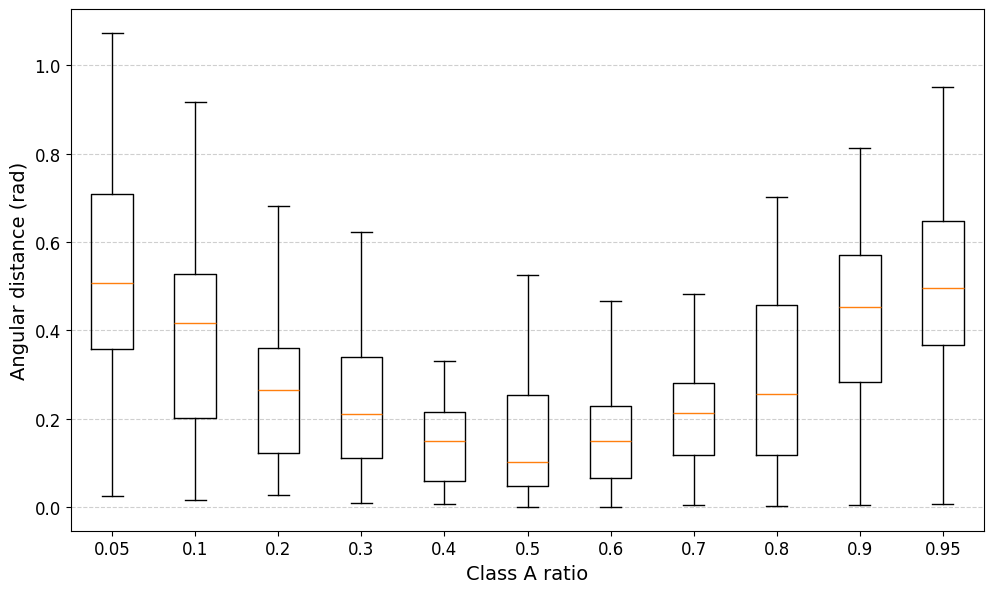

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_ylabel("Angular distance (rad)", fontsize=14)

# Sorted to keep x-axis ordered
ratios = sorted(ratio_distance.keys())
data = [ratio_distance[r] for r in ratios]

# Hide outliers with `showfliers=False`
ax.boxplot(data, tick_labels=[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95], showfliers=False)

ax.set_xlabel("Class A ratio", fontsize=14)
#ax.set_title("Angular distances per class ratio", fontsize=14)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
ax.tick_params(axis='both', labelsize=12)
plt.savefig("figs/Distance_per_class_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

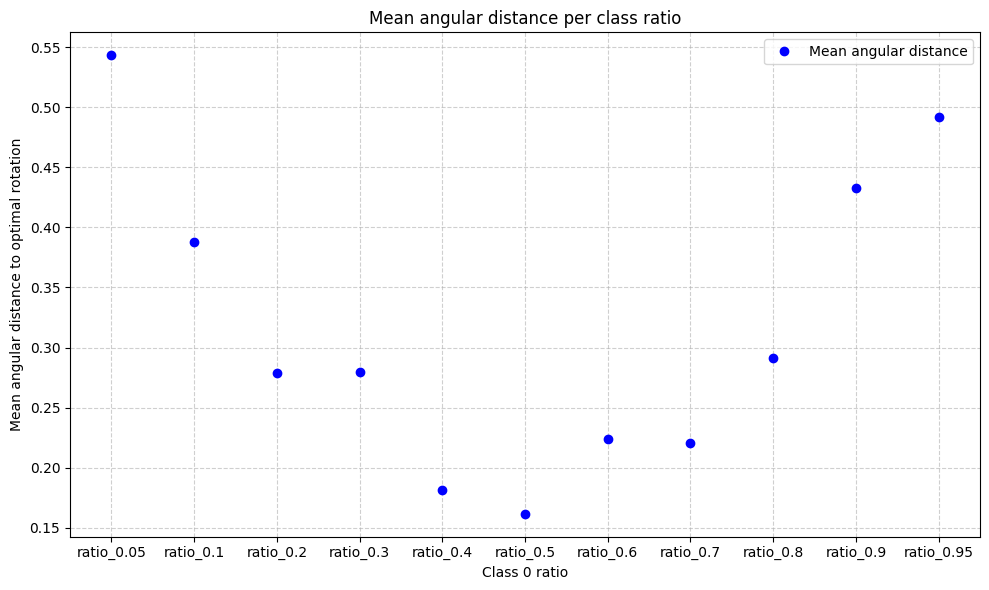

In [11]:
ratios = sorted(ratio_distance.keys())
means = [np.mean(ratio_distance[r]) for r in ratios]

plt.figure(figsize=(10, 6))
plt.plot(ratios, means, marker='o', linestyle='', color='b', label='Mean angular distance')
plt.xlabel("Class 0 ratio")
plt.ylabel("Mean angular distance to optimal rotation")
plt.title("Mean angular distance per class ratio")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
all_global_weights = []
for random_seed in np.arange(1,51):
    clients = create_clients_setup(num_clients=10, num_samples=100, sigma_range=(4., 4.), seed=random_seed)
    global_weights_evolution = run_federated_training(clients, num_rounds=20, round_batch_size=5, local_batch_size=1)
    all_global_weights.append(global_weights_evolution)

Param check [4.52593]
Param check [2.24479]
Param check [4.70471]
Param check [6.10787]
Param check [5.67008]
Param check [1.19681]
Param check [3.53606]
Param check [4.57517]
Param check [5.10708]
Param check [3.2513]

--- Round 1 ---
Updated parameters to: [4.62593]
Updated parameters to: [4.69293583]
Updated parameters to: [4.74473152]
Updated parameters to: [4.78715941]
Updated parameters to: [4.82302064]
Updated parameters to: [2.24479]
Updated parameters to: [2.24479]
Updated parameters to: [2.24479]
Updated parameters to: [2.24479]
Updated parameters to: [2.24479]
Updated parameters to: [4.80471]
Updated parameters to: [4.90471]
Updated parameters to: [4.98201029]
Updated parameters to: [5.06726847]
Updated parameters to: [5.13933108]
Updated parameters to: [6.20787]
Updated parameters to: [6.27487583]
Updated parameters to: [6.35667612]
Updated parameters to: [6.42368195]
Updated parameters to: [6.48031715]
Updated parameters to: [5.67008]
Updated parameters to: [5.74449368]
Up

In [13]:
# Convert to a NumPy array
arr = np.array(all_global_weights)  # Shape: (num_experiments, num_rounds)

# Compute element-wise mean and std across experiments
mean_array = np.mean(arr, axis=0)
std_array = np.std(arr, axis=0)

print("Mean per round:", mean_array)
print("Std per round:", std_array)

Mean per round: [2.3046799  2.21093975 1.72963023 1.73706465 1.76642719 1.65125503
 1.53091765 1.17685382 1.06762323 0.95378023 0.83791288 0.70855928
 0.7214857  0.74029539 0.729236   0.75152803 0.7663247  0.78464902
 0.79147291 0.79262136]
Std per round: [2.07073734 2.07276648 1.84064121 1.89722694 1.94797151 1.90563813
 1.84615464 1.4637959  1.30585357 1.0990536  0.81278526 0.25788712
 0.22961321 0.2025144  0.19609479 0.17969976 0.15663456 0.14700387
 0.14110117 0.13463056]


In [14]:
arr

array([[5.15348444, 5.39713875, 5.66637672, 5.88762453, 5.99450913,
        6.11871163, 6.25779245, 0.059459  , 0.16548445, 0.26398902,
        0.3081593 , 0.34034266, 0.46502141, 0.47064897, 0.50095957,
        0.5359974 , 0.59628918, 0.61259053, 0.59647498, 0.67935368],
       [5.45982249, 5.68344804, 5.91780278, 6.10297772, 6.21547172,
        0.05802793, 0.11044756, 0.25348601, 0.31539015, 0.40474814,
        0.41020108, 0.42834011, 0.47309895, 0.5022323 , 0.50028525,
        0.58287038, 0.61801714, 0.68808464, 0.70131519, 0.72700356],
       [5.35703667, 5.56908066, 5.83318973, 6.00295758, 6.10443286,
        6.19676555, 6.24970887, 0.09418766, 0.17119801, 0.24766053,
        0.25311347, 0.27456817, 0.33027812, 0.332973  , 0.33287811,
        0.36544802, 0.42643171, 0.47212612, 0.55615092, 0.6180906 ],
       [4.43420328, 4.64828004, 4.84298974, 5.00788329, 5.22529904,
        5.43360852, 5.57093736, 5.75685028, 5.96841546, 6.1066839 ,
        6.21592065, 0.01669231, 0.09700184, 0

In [15]:
new_arr = angular_distance(arr, 0.78)

In [16]:
mean_array = np.mean(new_arr, axis=0)
std_array = np.std(new_arr, axis=0)

print("Mean per round:", mean_array)
print("Std per round:", std_array)

Mean per round: [0.8588103  0.73237131 0.61192239 0.53404657 0.46320872 0.39835176
 0.37100544 0.3236383  0.27864121 0.24115234 0.21349399 0.1990999
 0.18090572 0.15516823 0.15606096 0.14755951 0.12647594 0.12852061
 0.12174909 0.11766203]
Std per round: [0.68143135 0.62387744 0.56425349 0.51908775 0.44862952 0.39913407
 0.34286804 0.30178297 0.26117701 0.22783241 0.20436873 0.17879814
 0.15303356 0.13605645 0.12913221 0.10643706 0.09340897 0.07151365
 0.072238   0.06663584]


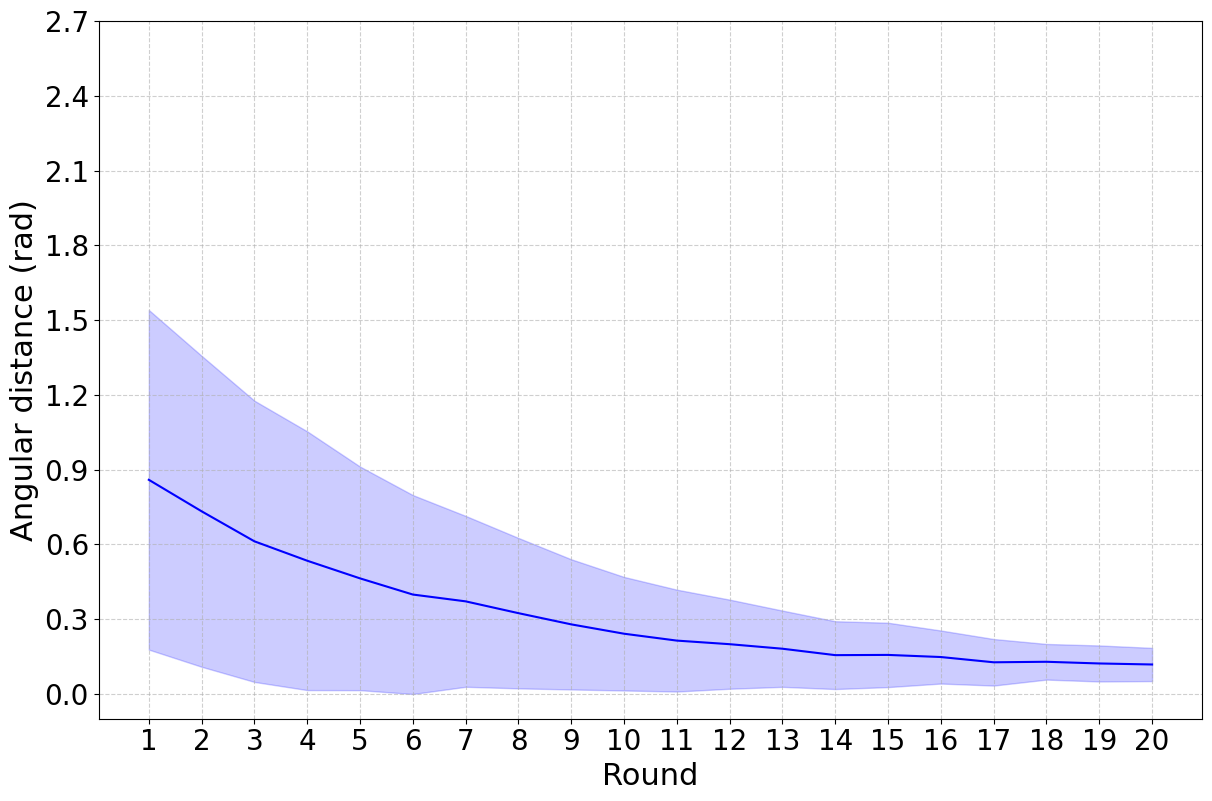

In [17]:
rounds = np.arange(1, 21)

# Plot
plt.figure(figsize=(12, 8))
plt.plot(rounds, mean_array, color='blue', label='Mean Global Weight')
plt.fill_between(rounds,
                 mean_array - std_array,
                 mean_array + std_array,
                 color='blue',
                 alpha=0.2,
                 label='± Std Dev')

plt.xlabel("Round", fontsize=22)
plt.ylabel("Angular distance (rad)", fontsize=22)
#plt.title("Average QFL Evolution", fontsize=22)
plt.xticks(rounds, fontsize=20)
plt.grid(True, linestyle='--', alpha=0.6)
#plt.legend()
plt.tight_layout()
plt.yticks(np.arange(0., 3., 0.3), fontsize=20)
plt.ylim(bottom=-0.1)
plt.savefig("figs/global_evolution.png", dpi=300, bbox_inches='tight')
plt.show()

In [18]:
local_results = []
for random_seed in np.arange(1,51):
    clients = create_clients_setup(num_clients=10, num_samples=100, sigma_range=(4., 4.), seed=random_seed)
    local_weights_list = []
    for client in clients:
        client.local_train(round_batch_size=client.num_samples, local_batch_size=1)
        local_weights_list.append(client.local_weights_evolution[0])
    local_results.append(local_weights_list)

Param check [4.52593]
Param check [2.24479]
Param check [4.70471]
Param check [6.10787]
Param check [5.67008]
Param check [1.19681]
Param check [3.53606]
Param check [4.57517]
Param check [5.10708]
Param check [3.2513]
Updated parameters to: [4.62593]
Updated parameters to: [4.69293583]
Updated parameters to: [4.74473152]
Updated parameters to: [4.78715941]
Updated parameters to: [4.82302064]
Updated parameters to: [4.85392839]
Updated parameters to: [4.90884584]
Updated parameters to: [4.95725886]
Updated parameters to: [5.00023685]
Updated parameters to: [5.05954804]
Updated parameters to: [5.11270202]
Updated parameters to: [5.16049463]
Updated parameters to: [5.2219376]
Updated parameters to: [5.27744629]
Updated parameters to: [5.32768044]
Updated parameters to: [5.37320527]
Updated parameters to: [5.41450972]
Updated parameters to: [5.45202027]
Updated parameters to: [5.4861115]
Updated parameters to: [5.51711437]
Updated parameters to: [5.54532277]
Updated parameters to: [5.5709

In [19]:
len(local_results[0][0])

100

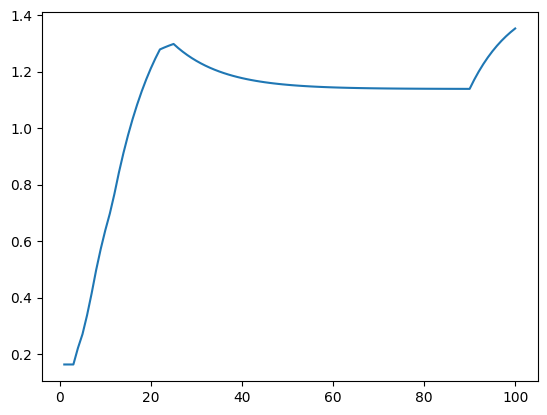

In [20]:
plt.plot(np.arange(1,101), local_results[1][0])

In [21]:
client_distance = angular_distance(local_results, 0.78)

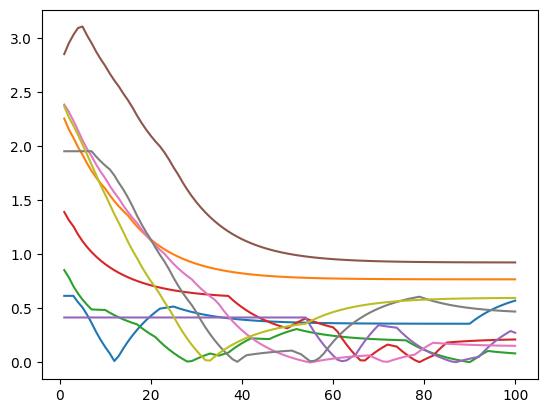

In [22]:
for client in np.arange(0,9):
    plt.plot(np.arange(1,101), client_distance[1][client])

In [23]:
# Assuming your data is stored in a NumPy array called `data`
# Shape: (19, 10, 100)
data = np.array(client_distance)  # Replace `your_list` with your actual variable

# Average over the first axis (19 experiments)
mean_per_client = np.mean(data, axis=0)  # Shape: (10, 100)

In [24]:
std_per_client = np.std(data, axis=0)  # Shape: (10, 100)

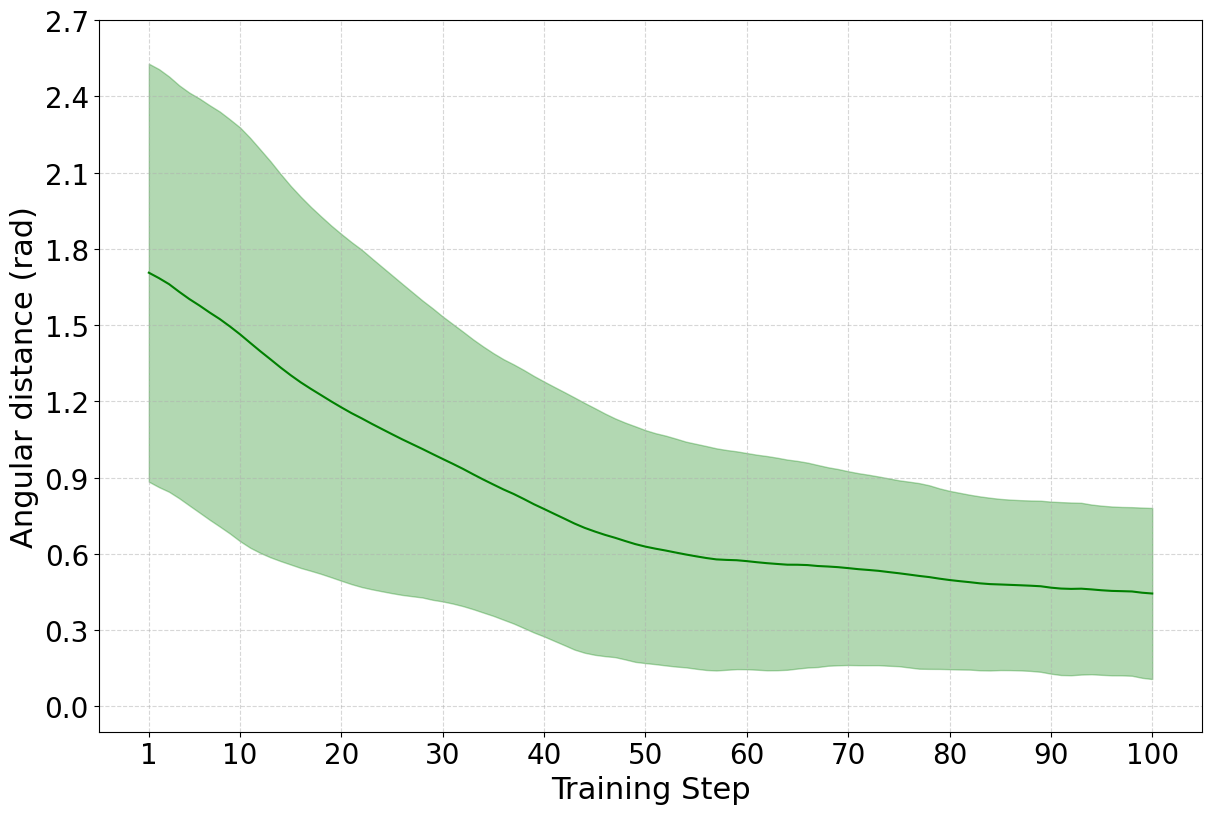

In [25]:
client_id = 0  # Choose client 0 through 9
rounds = np.arange(1, 101)

plt.figure(figsize=(12, 8))
plt.plot(rounds, mean_per_client[client_id], label=f"Client {client_id} Mean", color='green')
plt.fill_between(rounds,
                 mean_per_client[client_id] - std_per_client[client_id],
                 mean_per_client[client_id] + std_per_client[client_id],
                 color='green', alpha=0.3, label='±1 Std Dev')

#plt.title(f"Average Local Evolution - Client {client_id+1}", fontsize=22)
plt.xlabel("Training Step", fontsize=22)
plt.ylabel("Angular distance (rad)", fontsize=22)
#plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.yticks(np.arange(0., 3., 0.3), fontsize=20)
plt.xticks([1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], fontsize=20)
plt.ylim(bottom=-0.1)
plt.savefig("figs/local_evolution.png", dpi=300, bbox_inches='tight')
plt.show()